#  Stock Price Prediction
[insert project description]

## Table Of Contents
1. Data Introduction
        1.1. Technical Indicators
        1.2. Column Overview
        1.3. Column Value Overview

2. Descrptive and Error Analysis
        2.1. Overview
        2.2. Cleaning The Data
        2.3. Analytical Review 
                2.3.1. Observing the Closing Price
                2.3.2. Closing Price v Adjusted Closing Price
                2.3.3. Moving Average
                2.3.4. Feature Correlation
                2.3.5. Scatter Plot
                2.3.6. Feature Relevance

3. Data Pre-Proccesing
        3.1. Recreate Raw Database
        3.2. Pre-Process Data

4. Implementation and Results
        4.1. Results Evaluation Function
        4.2. RNN Model
        4.3. LSTM Model
        4.4. GRU Model

In [79]:
# Remove warnings
import warnings
warnings.simplefilter("ignore")

# Imports
from finta import TA
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [80]:
# Function to Deal with 'NaN' values
def remove_na(df, drop=False, fill=-1):
    '''
    Will drop missing values or replace them with a specified value.
    
    ----------
    PARAMETERS
    ----------
    Keyword arguments:
    dataframe: (pandas.core.frame.DataFrame) Dataframe object.
    drop: (bool) Determine if outliers and missing values should be dropped.
    fill: Number of standard deviations away from mean for outliers, with default value of 2.
    
    ----------
    OUTPUT
    ----------
    dataframe: (pandas.core.frame.DataFrame) Cleaned dataframe with no outliers or missing values.
    '''         
    # Deal with 'NaN' values
    if drop:
        df = df.dropna(axis=0) # Remove 
    else:
        df.fillna(fill, inplace=True) # replace with value to be masked

    return df

## 1.  Data Introduction
Pulling the neccessary data that will form the basis of the stock price prediction analysis

In [81]:
# Declare analysis; Ticker, Start Date, End Date
Ticker = 'TSCO.L'
start_date = '2016-04-01'
end_date = '2021-04-01'

df = yf.download(Ticker, start=start_date, end = end_date)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-04-01,240.919907,241.175705,235.409897,240.666504,182.715363,19756172
2016-04-04,240.919907,244.783203,239.083206,241.806503,183.580887,11173071
2016-04-05,239.463196,240.159897,234.839905,237.689896,180.455521,21640519
2016-04-06,238.006500,242.629898,237.689896,242.503204,184.109833,12610457
2016-04-07,243.263199,246.809906,240.413193,242.313202,183.965576,18690594


### 1.1. Technical Indicators
Include technical indicators in to the dataframe

In [82]:
# Choose the technical indicators as per the finTA documentation: https://pypi.org/project/finta/
technical_indicators = [TA.BBANDS, TA.STOCHD, TA.MACD, TA.RSI]

# Create Function to choose the technical Indicators
def tech_indicators(df, target, timeframe='24h', indicators = []):
    '''
    Adds columns of technical indicators to the dataframe.
    
    ----------
    PARAMETERS
    ----------
    df: (pandas.core.frame.DataFrame) Dataframe object.
    target: (str) Target feature of the model.
    y_test: (str) Amount of time between observations where daily would be '24h'.
    indicators: (list) Indicators to add to the dataframe from finTA.
    ----------
    OUTPUT
    ----------
    df: (pandas.core.frame.DataFrame) Dataframe object with the added techincal indicators.
    '''
    # Format columns to be compatibale with finTA
    target = target.lower()
    df.columns = [x.lower() for x in df.columns]
    ohlc = df[target].resample(timeframe).ohlc()
    
    # Remove NaN values as the ohlc object would have created them on non-trasing days
    ohlc = remove_na(ohlc, drop=True)
     
    # Add the specified technical Indicators
    for i in indicators:
        df = df.merge(i(ohlc), on='Date', how='inner')
    
    df.columns = [x.title() for x in df.columns]
    
    # Return dataframe
    return df

# Update dataframe to include technical indicators
df = tech_indicators(df, target = 'Close',indicators = technical_indicators)
df

,Open,High,Low,Close,Adj Close,Volume,Bb_Upper,Bb_Middle,Bb_Lower,3 Period Stoch %D.,Macd,Signal,14 Period Rsi
Date,,,,,,,,,,,,,
2016-04-01,240.919907,241.175705,235.409897,240.666504,182.715363,19756172,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
2016-04-04,240.919907,244.783203,239.083206,241.806503,183.580887,11173071,NaN,NaN,NaN,NaN,0.025577,0.014209,100.000000
2016-04-05,239.463196,240.159897,234.839905,237.689896,180.455521,21640519,NaN,NaN,NaN,NaN,-0.095066,-0.030575,20.454770
2016-04-06,238.006500,242.629898,237.689896,242.503204,184.109833,12610457,NaN,NaN,NaN,NaN,0.026176,-0.011351,60.259578
2016-04-07,243.263199,246.809906,240.413193,242.313202,183.965576,18690594,NaN,NaN,NaN,NaN,0.083945,0.016998,59.004398
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-25,227.899994,230.300003,226.899994,227.699997,227.699997,32273714,312.636437,213.14305,113.649663,99.604111,-8.932740,-14.689860,50.756248
2021-03-26,228.600006,228.699997,227.000000,228.600006,228.600006,13590623,312.934623,213.33305,113.731478,99.486814,-6.925732,-13.137034,50.864952
2021-03-29,230.000000,230.100006,226.399994,228.300003,228.300003,14846386,313.363787,213.61805,113.872314,99.384178,-5.298296,-11.569287,50.824677


### 1.2.  Column Overview
Understand the nature of the columns for the dataset as a whole

In [83]:
# Observe basic information of the columns in the dataset
print('INFORMATION ON THE E-COMMERCE DATA SET:')
print(df.info())
print('\n\nCOLUMNS IN THE E-COMMERCE DATA SET:\n',df.columns)

INFORMATION ON THE E-COMMERCE DATA SET:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1266 entries, 2016-04-01 to 2021-03-31
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Open                1266 non-null   float64
 1   High                1266 non-null   float64
 2   Low                 1266 non-null   float64
 3   Close               1266 non-null   float64
 4   Adj Close           1266 non-null   float64
 5   Volume              1266 non-null   int64  
 6   Bb_Upper            1247 non-null   float64
 7   Bb_Middle           1247 non-null   float64
 8   Bb_Lower            1247 non-null   float64
 9   3 Period Stoch %D.  1251 non-null   float64
 10  Macd                1266 non-null   float64
 11  Signal              1266 non-null   float64
 12  14 Period Rsi       1265 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 138.5 KB
None


COLUMNS IN THE E-COMMERCE DATA SET:
 Ind

### 1.3. Column Value Overview
Taking a closer look into the nature of the values within each dataset

In [84]:
# Understand values within each column
print('NUMBER OF NaN VALUES:\n',df.isna().sum())
print('\nSTATISTICAL INFORMATION OF COLUMNS:\n',df.describe())

NUMBER OF NaN VALUES:
 Open                   0
High                   0
Low                    0
Close                  0
Adj Close              0
Volume                 0
Bb_Upper              19
Bb_Middle             19
Bb_Lower              19
3 Period Stoch %D.    15
Macd                   0
Signal                 0
14 Period Rsi          1
dtype: int64

STATISTICAL INFORMATION OF COLUMNS:
               Open         High          Low        Close    Adj Close  \
count  1266.000000  1266.000000  1266.000000  1266.000000  1266.000000   
mean    268.584126   271.789957   265.571825   268.622001   211.174391   
std      36.416791    36.881804    36.166028    36.405698    31.450838   
min       2.257000     2.276000     2.227200     2.231000     2.231000   
25%     238.465729   240.930923   235.900696   238.655720   183.977589   
50%     272.333191   275.689850   269.008148   272.333191   219.597122   
75%     297.413208   301.054817   294.246490   297.634827   236.755814   
max     3

## 2. Descriptive and Error Analysis 

### 2.1. Overview
Gain basic insight into the statistical nature of the columns

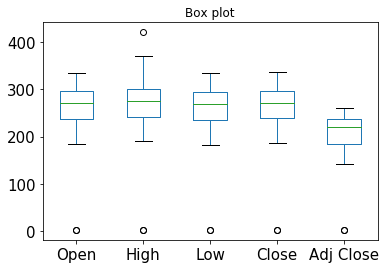

In [85]:
#data[['Open','High']]
df1 = df[['Open', 'High', 'Low', 'Close', 'Adj Close']]

# Create Boxplot
plt.title("Box plot")
df1.boxplot(grid=False, fontsize=15)

### 2.2. Cleaning the Data
Create Fuctions to remove outliers and remove NaN values for the descriptive analytics process

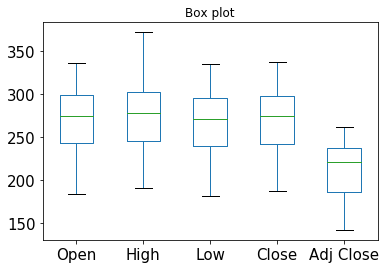

In [86]:
# Function to Remove Outliers
def remove_outliers(df, max_dev=3):
    '''
    Removes outliers  from the data.
    
    ----------
    PARAMETERS
    ----------
    Keyword arguments:
    dataframe: (pandas.core.frame.DataFrame) Dataframe object.
    max_dev: (num) Number of standard deviations away from mean for outliers, with default value of 2
    
    ----------
    OUTPUT
    ----------
    dataframe: (pandas.core.frame.DataFrame) Cleaned dataframe with no outliers.
    '''         
    # Deal with Outliers
    mean = np.mean(df)
    std_dev = np.std(df)
    dist_mean = abs(df-mean)
    non_outliers = dist_mean < std_dev * max_dev
    return df[non_outliers]


# Remove Outliers
df = remove_outliers(df, max_dev=3)

#Remove NaN Values
df = remove_na(df, drop=True)

# Observe Updates in Data after cleaning
df1 = df[['Open', 'High', 'Low', 'Close', 'Adj Close']]

plt.title("Box plot")
df1.boxplot(grid=False, fontsize=15)

### 2.3. Analytical Review
Exploring the nature of the data and their relationships with the target feature

In [87]:
len(df)

1196

#### 2.3.1. Observing the Closing Price

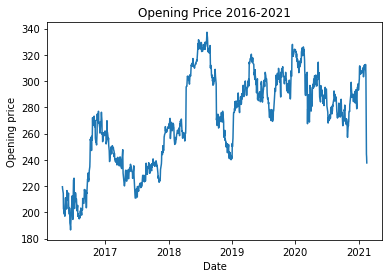

In [88]:
plt.title('Opening Price 2016-2021')
plt.rc('figure', figsize=(8, 7))
plt.xlabel('Date')
plt.ylabel('Opening price')
plt.plot(df['Close'])

plt.show()

#### 2.3.2. Closing Prive v Adjusted Closing Price

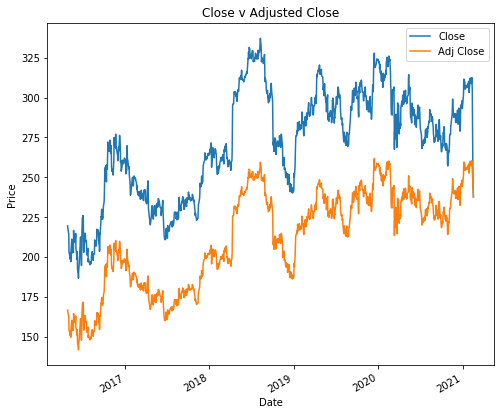

In [89]:

app = df[['Close', 'Adj Close']].plot()
fig1 = app.get_figure()
plt.rc('figure', figsize=(8, 7))
plt.title('Close v Adjusted Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

#### 2.3.3. Moving Average

Date
2016-04-28           NaN
2016-04-29           NaN
2016-05-03           NaN
2016-05-04           NaN
2016-05-05           NaN
                 ...    
2021-02-11    239.325381
2021-02-12    239.519053
2021-02-15    239.613768
2021-02-16    239.709319
2021-02-17    239.807737
Name: Adj Close, Length: 1196, dtype: float64


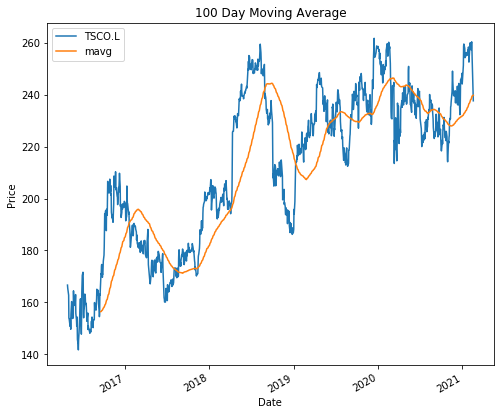

In [90]:
close_px = df['Adj Close']

mavg = close_px.rolling(window=100).mean()
print(mavg)
plt.rc('figure', figsize=(8, 7))
plt.title('100 Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')

close_px.plot(label='TSCO.L')
mavg.plot(label='mavg')

plt.legend()

#### 2.3.4. Feature Correlation

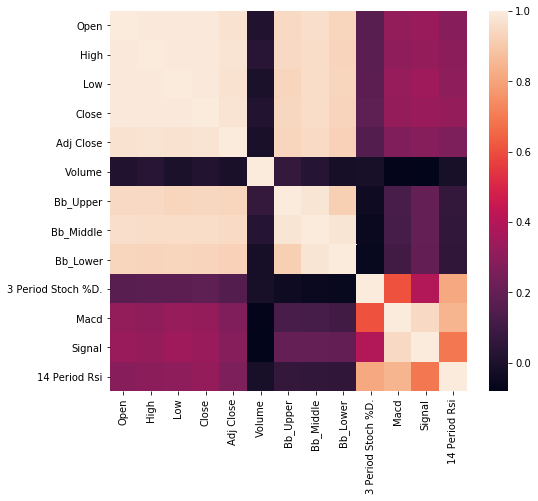

In [91]:
sns.heatmap(df.corr())

#### 2.3.5. Scatter Plot

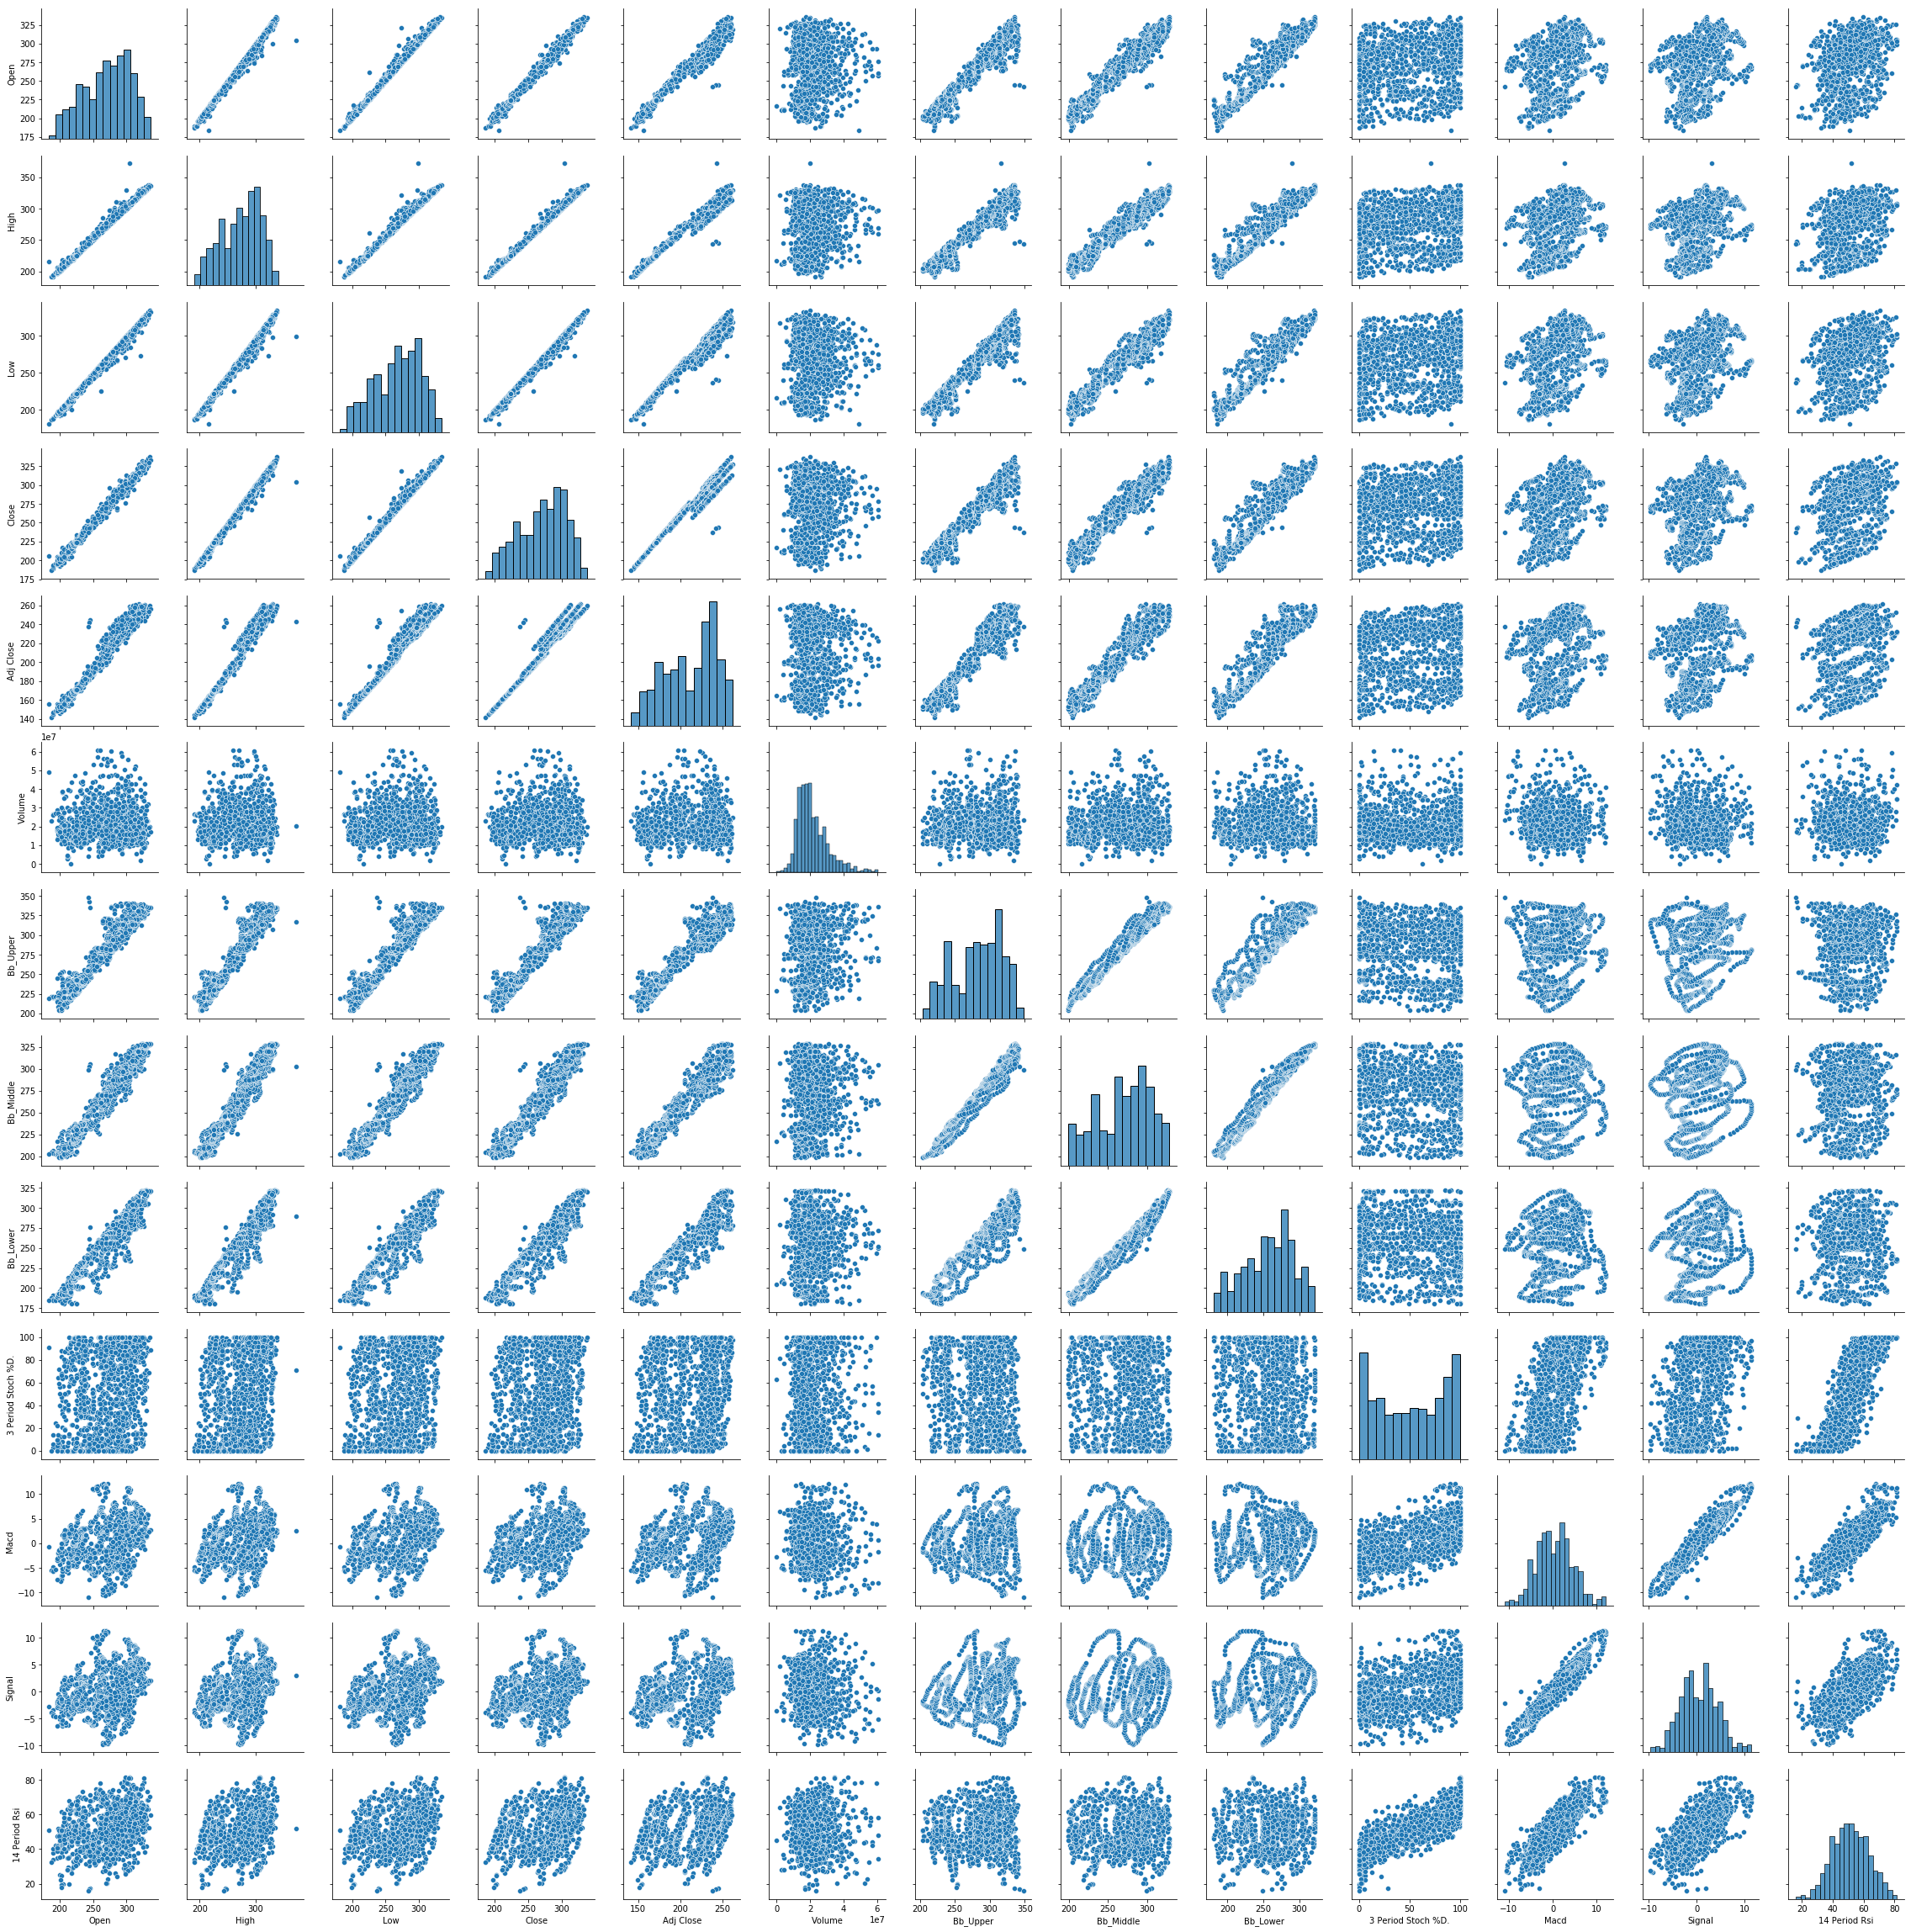

In [52]:
sns.pairplot(df)

#### 2.3.6. Feature Relevance
Calculated Using the Pearson Correlation Coefficient

In [92]:
# Imports
from scipy.stats import pearsonr

# Specify Target
target = 'Close'


kc_dic = {}
for feature in df:
    kc_dic[feature] = pearsonr(df[feature], df[target])
    
kc_df = pd.DataFrame.from_dict(kc_dic, orient='index')
kc_df['Correlation'] = round(kc_df[0],2)
kc_df['P-Value'] = round(kc_df[1],6)
kc_df = kc_df.drop(columns=[0,1])
kc_df = kc_df.sort_values(['Correlation'], ascending=False)
kc_df

,Correlation,P-Value
High,1.00,0.000000
Low,1.00,0.000000
Close,1.00,0.000000
Open,0.99,0.000000
Adj Close,0.98,0.000000
Bb_Middle,0.96,0.000000
Bb_Upper,0.94,0.000000
Bb_Lower,0.94,0.000000
Signal,0.33,0.000000
Macd,0.32,0.000000


## 3. Data Pre-Processing

### 3.1. Recreate Raw Database
In this section the raw data is pulled and dealt with for the purpose of executing the machine learning models. This needs to be differentiated from the Analytical database since outliers and NaN values will need to be handled differently

In [122]:
# Pull raw data base for Tesco, Morrisons and Sainsburys
df_t = yf.download('TSCO.L', start=start_date, end = end_date)
df_m = yf.download('MRW.L', start=start_date, end = end_date)
df_s = yf.download('SBRY.L', start=start_date, end = end_date)
# Import the same technical indicators as before
technical_indicators = [TA.BBANDS, TA.STOCHD, TA.MACD, TA.RSI]
dft_t = tech_indicators(df_t, target = 'Adj Close', indicators = technical_indicators)
dft_m = tech_indicators(df_m, target = 'Adj Close', indicators = technical_indicators)
dft_s = tech_indicators(df_s, target = 'Adj Close', indicators = technical_indicators)

# # Remove outliers
df_t = remove_outliers(df_t)
df_m = remove_outliers(df_m)
df_s = remove_outliers(df_s)
dft_t = remove_outliers(dft_t)
dft_m = remove_outliers(dft_m)
dft_s = remove_outliers(dft_s)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### 3.2. Pre-Process Data
Pre-Process the data sequentially, to prepare it correctly for a sequential based model.

In [133]:
# Create a function to pre-process the data
def transform_data(df, target, timestep=7, split=0.7, forecast=1, features=[]):
    '''
    Pre-processes a dataframe into a sequential manner for use in a recurrent nueral network.
    
    ----------
    PARAMETERS
    ----------
    dataframe: (pandas.core.frame.DataFrame) Dataframe object.
    target: (str) Value of target feature.
    timestep: (int) Number of previouse periods to use for predictor variable(s), with default of 7 periods.
    split: (float) Training test split percentage, given as value between (0,1) with default of 0.7.
    forecast: (int) Number of periods to forecast with default of 1 period ahead.
    features: List of features to REMOVE from the dataframe.
    
    ----------
    OUTPUT
    ----------
    x_train: (numpy.ndarray) Predictor variable(s) values used for training.
    y_train: (numpy.ndarray) Target variable values used for training.
    x_test: (numpy.ndarray) Predictor variable(s) values used for testing.
    y_test: (numpy.ndarray) Target variable values used for testing.
    sc: (sklearn.preprocessing._data.MinMaxScaler) Scaler object.
    '''
    
    #Combine features
    df = df.drop(columns=features)
    df = df[ [target] + [ col for col in df.columns if col != target ] ]
    
    # Creating test and training data
    train, test = np.split(df, [int(split*len(df))])
    
    # Scale the data for training
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0, 1))
    train_data_trans = sc.fit_transform(train)
    test_data_trans = sc.fit_transform(test)

    
    # Create Training and X_Test objects
    x_train_data, y_train_data, x_test_data , y_test_data = [], [], [], []
    

        
    # Create Training set in correct sequence
    for i in range(timestep, len(train_data_trans)- forecast + 1):
        x_train_data.append(train_data_trans[i-timestep:i, :])
        y_train_data.append(train_data_trans[i:(i+forecast), 0])
            
    # Create Test set in the correct sequence
    for i in range(timestep, len(test_data_trans) - forecast + 1):
        x_test_data.append(test_data_trans[i-timestep:i, :])
        y_test_data.append(test_data_trans[i:(i+forecast), 0])
               
    
    # Format training and test data sets
    x_train, y_train, x_test, y_test = np.array(x_train_data), np.array(y_train_data), np.array(x_test_data), np.array(y_test_data)

    
#     # Reshape the training and test data
#     x_train = np.reshape(x_train, (x_train.shape[1], x_train.shape[2], x_train.shape[0]))    
#     x_test = np.reshape(x_test, (x_test.shape[1], x_test.shape[2], x_test.shape[0]))
    
    
    # Return training Data
    return x_train, y_train, x_test, y_test, sc

# Establishing training and test sets 
X_train_t, y_train_t, X_test_t, y_test_t, sc_t = transform_data(df_t, target='adj close', features =['high', 'open', 'low','close','volume'])
X_train_m, y_train_m, X_test_m, y_test_m, sc_m = transform_data(df_m, target='adj close', features = ['high', 'open', 'low','close','volume'])
X_train_s, y_train_s, X_test_s, y_test_s, sc_s = transform_data(df_s, target='adj close', features = ['high', 'open', 'low','close','volume'])
X_train_t_t, y_train_t_t, X_test_t_t, y_test_t_t, sc_t_t = transform_data(dft_t, target='Adj Close', features = ['Volume','3 Period Stoch %D.'])
X_train_t_m, y_train_t_m, X_test_t_m, y_test_t_m, sc_t_m = transform_data(dft_m, target='Adj Close', features = ['Volume','3 Period Stoch %D.'])
X_train_t_s, y_train_t_s, X_test_t_s, y_test_t_s, sc_t_s = transform_data(dft_s, target='Adj Close', features = ['Volume','3 Period Stoch %D.'])
# Assign NaN Values to -1 so they can be masked on the model implementation
X_train_t, y_train_t, X_test_t, y_test_t = np.nan_to_num(X_train_t, nan=-1), np.nan_to_num(y_train_t, nan=-1), np.nan_to_num(X_test_t, nan=-1), np.nan_to_num(y_test_t, nan=-1)
X_train_m, y_train_m, X_test_m, y_test_m = np.nan_to_num(X_train_m, nan=-1), np.nan_to_num(y_train_m, nan=-1), np.nan_to_num(X_test_m, nan=-1), np.nan_to_num(y_test_m, nan=-1)
X_train_s, y_train_s, X_test_s, y_test_s = np.nan_to_num(X_train_s, nan=-1), np.nan_to_num(y_train_s, nan=-1), np.nan_to_num(X_test_s, nan=-1), np.nan_to_num(y_test_s, nan=-1)
X_train_t_t, y_train_t_t, X_test_t_t, y_test_t_t = np.nan_to_num(X_train_t_t, nan=-1), np.nan_to_num(y_train_t_t, nan=-1), np.nan_to_num(X_test_t_t, nan=-1), np.nan_to_num(y_test_t_t, nan=-1)
X_train_t_m, y_train_t_m, X_test_t_m, y_test_t_m = np.nan_to_num(X_train_t_m, nan=-1), np.nan_to_num(y_train_t_m, nan=-1), np.nan_to_num(X_test_t_m, nan=-1), np.nan_to_num(y_test_t_m, nan=-1)
X_train_t_s, y_train_t_s, X_test_t_s, y_test_t_s = np.nan_to_num(X_train_t_s, nan=-1), np.nan_to_num(y_train_t_s, nan=-1), np.nan_to_num(X_test_t_s, nan=-1), np.nan_to_num(y_test_t_s, nan=-1)

## 4. Implementation and Results
Run and evaluate the results of the following functions:
- Basic RNN Model
- LSTM Model
- GRU Model

In [97]:
def __init__(self, function, output_shape=None,
             mask=None, arguments=None, **kwargs):
    # ...
    if mask is not None:
        self.supports_masking = True
    self.mask = mask

# ...

def compute_mask(self, inputs, mask=None):
    if callable(self.mask):
        return self.mask(inputs, mask)
    return self.mask

In [98]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Masking
from keras.layers import Lambda as Lambda

def build_LSTM(
    X_train,
    Y_train,
    Units=50,
    Layers=3,
    Epochs=50,
    Dropout_level=0.2,
    Loss_method='mean_squared_error',
    Optimizer_method='adam',
    Batch_size=72,
    Validation_split = 0.1,
    Verbose = 0,
    Shuffle=False
):
    
    """Builds and trains LSTM model for stock-price prediction
    ----------
    PARAMETERS
    ----------
    X_train: (np.array) Supervised learning x_training data
    Y_train: (np.array) Supervised learning y_training data
    Units: (int) Number of hidden units in each LSTM layer
    Layers: (int) Number of LSTM layers
    Dropout_level: (float) Fraction of input data to drop
    Batch_size: (int) Number of samples to use per gradient update
    Validation_split: (float) Fraction of training data to use for validation
    Verbose: (int) To recieve model updates per epoch (0 for none, 2 for per epoch)
    
    ----------
    OUTPUT
    ----------
    model: LSTM model (keras.Sequential) fitted model
    model_history : (keras.callback.history) history of model training
    """
    ## Inital model
    masking_func = lambda inputs, previous_mask: previous_mask[:, 6:]
    model = Sequential()
    model.add(Masking(mask_value=-1, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=Units, return_sequences=True, input_shape =(X_train.shape[1],X_train.shape[2])))
    model.add(Dropout(Dropout_level))
    
    num_layers=0
    ## Adding layers to model
    while num_layers <= (Layers-1):
        model.add(LSTM(units=Units,return_sequences=True))
        model.add(Dropout(Dropout_level))
        num_layers += 1
        
    ## Adding final layer    
    model.add(Dense(1))
    
    ## Building model
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.add(Lambda(lambda x: x[:, 6:, :], mask=masking_func))
    ## Fitting model
    fitted_model = model.fit(X_train, Y_train,
                            epochs=50, batch_size=Batch_size,
                            validation_split = Validation_split,
                            verbose=Verbose)
    
    return model, fitted_model

In [99]:
from keras.layers import GRU
## This function builds a model only
def build_GRU(
    X_train,
    Y_train,
    Units=50,
    Layers=3,
    Dropout_level=0.2,
    Batch_size=72,
    Validation_split = 0.1,
    Verbose = 0,
):
    
    """Builds and trains GRU model for stock-price prediction
    ----------
    PARAMETERS
    ----------
    X_train: (np.array) Supervised learning x_training data
    Y_train: (np.array) Supervised learning y_training data
    Units: (int) Number of hidden units in each GRU layer
    Layers: (int) Number of GRU layers
    Dropout_level: (float) Fraction of input data to drop
    Batch_size: (int) Number of samples to use per gradient update
    Validation_split: (float) Fraction of training data to use for validation
    Verbose: (int) To recieve model updates per epoch (0 for none, 2 for per epoch)
    
    ----------
    OUTPUT
    ----------
    model: GRU model (keras.Sequential) fitted model
    model_history : (keras.callback.history) history of model training
    """
    ## Inital model
    masking_func = lambda inputs, previous_mask: previous_mask[:, 6:]
    model = Sequential()
    model.add(Masking(mask_value=-1, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(GRU(units=Units, return_sequences=True, input_shape =(X_train.shape[1],X_train.shape[2])))
    model.add(Dropout(Dropout_level))
    
    num_layers=0
    ## Adding layers to model
    while num_layers <= (Layers-1):
        model.add(GRU(units=Units,return_sequences=True))
        model.add(Dropout(Dropout_level))
        num_layers += 1
        
    ## Adding final layer    
    model.add(Dense(1))
    
    ## Building model
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.add(Lambda(lambda x: x[:, 6:, :], mask=masking_func))
    ## Fitting model
    fitted_model = model.fit(X_train, Y_train,
                            epochs=50, batch_size=Batch_size,
                            validation_split = Validation_split,
                            verbose=Verbose)
    
    return model, fitted_model

In [100]:
## This function creates the model and also calculates the RMSE

from sklearn.metrics import mean_squared_error

def evaluate_model(model_type,
                   X_train,
                   Y_train,
                   X_test,
                   Y_test,
                   Units=50,
                   Layers=3,
                   Dropout_level=0.2,
                   Batch_size=72,
                   Validation_split=0.1
):
    
    if model_type == 'LSTM':
        print('Building LSTM')
        model, model_history = build_LSTM(X_train, Y_train, Units=Units, Layers=Layers,
                                          Dropout_level=Dropout_level, Batch_size=Batch_size, Validation_split=Validation_split)
    if model_type =='GRU':
        print('Building GRU')
        model, model_history = build_GRU(X_train, Y_train, Units=Units, Layers=Layers,
                                          Dropout_level=Dropout_level, Batch_size=Batch_size, Validation_split=Validation_split)
    
    yhat = model.predict(X_test)
    yhat = yhat.reshape((len(yhat)),)
    # Extend yhat array so its fits the size of the scaler
    yhat_extended = np.zeros((len(yhat),X_test.shape[2]))
    # Put the predictions there
    yhat_extended[:,0] = yhat
    # Inverse transform it and select the 3rd column.
    inv_yhat = sc.inverse_transform(yhat_extended)[:,0]
    # invert scaling for actual
    y_test = Y_test.reshape((len(Y_test),))
    ytest_extended = np.zeros((len(y_test),X_test.shape[2]))
    ytest_extended[:,0] = y_test
    inv_y = sc.inverse_transform(ytest_extended)[:,0]
     # calculate RMSE
    rmse = mean_squared_error(inv_y, inv_yhat, squared=False)
    print('\n###################\nTest RMSE: %.3f\n###################\n' % rmse)

    return rmse

## Paramterisation- cells are commented out because they take long to run
## Completed on TESCO 1 feature

In [182]:
'''
scores = {}
for layers in range(1,7):
    scores[layers] = evaluate_model(model_type='LSTM', X_train=X_train_t, Y_train=y_train_t, X_test=X_test_t, Y_test=y_test_t, Layers=layers)
scores
'''

Building LSTM

###################
Test RMSE: 7.729
###################

Building LSTM

###################
Test RMSE: 8.516
###################

Building LSTM

###################
Test RMSE: 8.852
###################

Building LSTM

###################
Test RMSE: 9.024
###################

Building LSTM

###################
Test RMSE: 9.124
###################

Building LSTM

###################
Test RMSE: 9.267
###################



{1: 7.729244146027778,
 2: 8.516085275799707,
 3: 8.852232715864783,
 4: 9.02365779319878,
 5: 9.124037544828896,
 6: 9.267371040343287}

In [102]:
"""
scores = {}
unitz = [40,45,50,55,60]
for units in unitz:
    scores[units] = evaluate_model(model_type='LSTM', X_train=X_train_t, Y_train=y_train_t, X_test=X_test_t, Y_test=y_test_t, Layers=2,units=units )
scores
"""

"\nscores = {}\nunitz = [40,45,50,55,60]\nfor units in unitz:\n    scores[units] = evaluate_model(model_type='LSTM', X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, Layers=2,units=units )\nscores\n"

In [183]:
'''
scores = {}
batches = [21,42,70,84,98,126,252]
for batch in batches:
    scores[batch] = evaluate_model(model_type='LSTM', X_train=X_train_t, Y_train=y_train_t, X_test=X_test_t, Y_test=y_test_t, Layers=2, Batch_size=batch)
scores'''


Building LSTM

###################
Test RMSE: 7.209
###################

Building LSTM

###################
Test RMSE: 8.141
###################

Building LSTM

###################
Test RMSE: 8.391
###################

Building LSTM

###################
Test RMSE: 8.400
###################

Building LSTM

###################
Test RMSE: 8.571
###################

Building LSTM

###################
Test RMSE: 8.516
###################

Building LSTM

###################
Test RMSE: 8.535
###################



{21: 7.2086798303931845,
 42: 8.140751526712311,
 70: 8.391411266359105,
 84: 8.400324713369786,
 98: 8.57132299467459,
 126: 8.515602208653567,
 252: 8.535415677197555}

In [104]:
"""
scores = {}
dropouts = [0.1,0.2,0.25,0.3]
for dropout in dropouts:
    scores[dropout] = evaluate_model(model_type='LSTM', X_train=X_train_t, Y_train=y_train_t, X_test=X_test_t, Y_test=y_test_t, Layers=2, Dropout_level=dropout)
scores
"""

"\nscores = {}\ndropouts = [0.1,0.2,0.25,0.3]\nfor dropout in dropouts:\n    scores[dropout] = evaluate_model(model_type='LSTM', X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, Layers=2, Dropout_level=dropout)\nscores\n"

In [105]:
"""
scores = {}
validsplits = [0.05,0.1,0.15,0.2,0.25]
for vs in validsplits:
    scores[vs] = evaluate_model(model_type='LSTM', X_train=X_train_t, Y_train=y_train_t, X_test=X_test_t, Y_test=y_test_t, 
                                     Layers=2, Dropout_level=0.25, Validation_split=vs)
scores
"""

"\nscores = {}\nvalidsplits = [0.05,0.1,0.15,0.2,0.25]\nfor vs in validsplits:\n    scores[vs] = evaluate_model(model_type='LSTM', X_train=X_train, Y_train=y_train, X_test=X_test, Y_test=y_test, \n                                     Layers=2, Dropout_level=0.25, Validation_split=vs)\nscores\n"

In [124]:
def retrieve_yvals(model, scaler, X_test, y_test):
    
    '''
    '''
    yhat = model.predict(X_test)
    yhat = yhat.reshape((len(yhat)),)
    # Extend yhat array so its fits the size of the scaler
    yhat_extended = np.zeros((len(yhat),X_test.shape[2]))
    # Put the predictions there
    yhat_extended[:,0] = yhat
    # Inverse transform it and select the 3rd column.
    inv_yhat = scaler.inverse_transform(yhat_extended)[:,0]
    # invert scaling for actual
    y_test = y_test.reshape((len(y_test),))
    ytest_extended = np.zeros((len(y_test),X_test.shape[2]))
    ytest_extended[:,0] = y_test
    inv_y = scaler.inverse_transform(ytest_extended)[:,0]
    
    return inv_yhat, inv_y

In [125]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def model_results(model, model_fitted, scaler, X_test, y_test):
    '''
    Displays model results relative to actual results using the test set to make prediction.
    
    ----------
    PARAMETERS
    ----------
    dataframe: (tensorflow.python.keras.engine.sequential.Sequential) Sequential Model.
    X_test: (numpy.ndarray) Explanatory variable from test set.
    y_test: (numpy.ndarray) Actual results from the test set.
    
    ----------
    OUTPUT
    ----------
    Root Mean Squared Error of the model.
    Training History plot.
    Results v Actual plot.
    '''
    inv_yhat, inv_y = retrieve_yvals(model, scaler, X_test, y_test)
    
     # calculate RMSE
    rmse = mean_squared_error(inv_y, inv_yhat, squared=False)
    mae = mean_absolute_error(inv_y, inv_yhat)
    r2 = r2_score(inv_y, inv_yhat)
    print('\n###################\nTest RMSE: %.3f\n###################\n' % rmse)
    print('\n###################\nTest MAE: %.3f\n###################\n' % mae)
    print('\n###################\nTest R2: %.3f\n###################\n' % r2)
 

## Best Model - tesco

In [134]:
#LSTM only adj close feature
model_t, model_history_t = build_LSTM(X_train_t, y_train_t,
                                  Validation_split=0.2,
                                  Dropout_level=0.25 ,
                                  Batch_size=84,
                                  Layers=2
                                 )

In [136]:
model_results(model_t, model_history_t, scaler = sc_t, X_test=X_test_t ,y_test=y_test_t)


###################
Test RMSE: 8.660
###################


###################
Test MAE: 5.425
###################


###################
Test R2: 0.535
###################



In [137]:
# LSTMmultiple features
model_t_t, model_history_t_t = build_LSTM(X_train_t_t, y_train_t_t,
                                  Validation_split=0.2,
                                  Dropout_level=0.25 ,
                                  Batch_size=84,
                                  Layers=2
                                 )

In [138]:
model_results(model_t_t, model_history_t_t, scaler = sc_t_t, X_test=X_test_t_t ,y_test=y_test_t_t)


###################
Test RMSE: 8.369
###################


###################
Test MAE: 5.864
###################


###################
Test R2: 0.566
###################



In [108]:
#GRU with only adj close
modelg_t, modelg_history_t = build_GRU(X_train_t, y_train_t,
                                  Validation_split=0.2,
                                  Dropout_level=0.25 ,
                                  Batch_size=84,
                                  Layers=2
                                 )

In [139]:
model_results(modelg_t, modelg_history_t, scaler = sc_t, X_test=X_test_t ,y_test=y_test_t)


###################
Test RMSE: 7.307
###################


###################
Test MAE: 4.464
###################


###################
Test R2: 0.669
###################



In [140]:
#GRU with multiple features
modelg_t_t, modelg_history_t_t = build_GRU(X_train_t_t, y_train_t_t,
                                  Validation_split=0.2,
                                  Dropout_level=0.25 ,
                                  Batch_size=84,
                                  Layers=2
                                 )

In [141]:
model_results(modelg_t_t, modelg_history_t_t, scaler = sc_t_t, X_test=X_test_t_t ,y_test=y_test_t_t)


###################
Test RMSE: 7.681
###################


###################
Test MAE: 5.330
###################


###################
Test R2: 0.634
###################



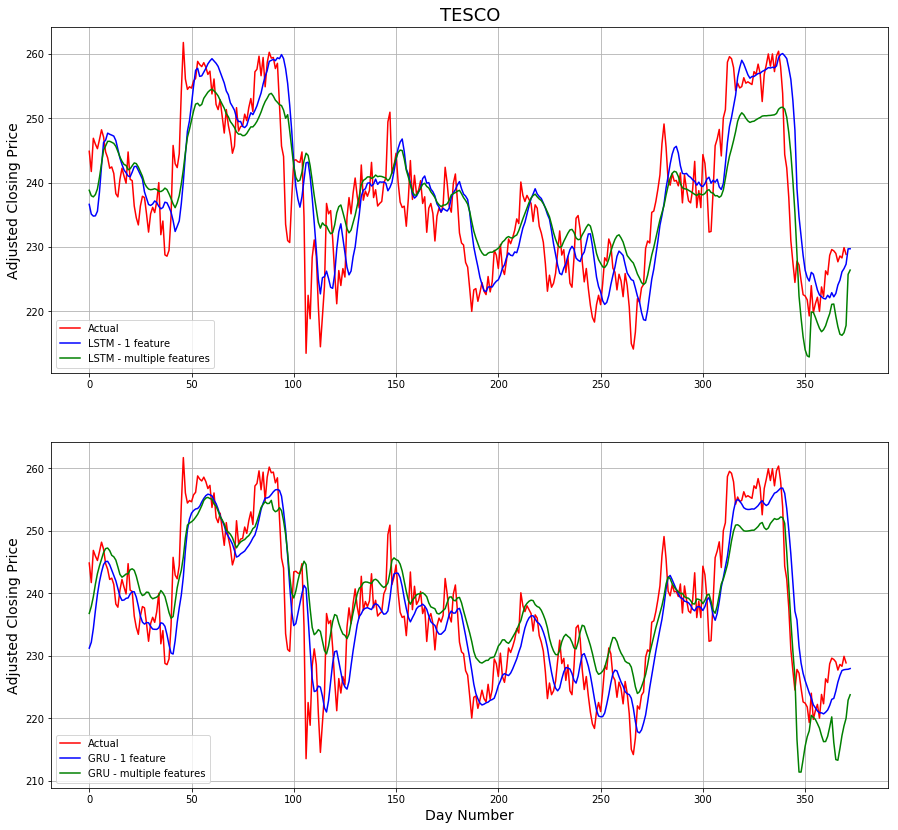

In [178]:
f = plt.figure(figsize=(15,14))
plt.subplot(211)
inv_yhat_lstm1, inv_y = retrieve_yvals(model=model_t, scaler=sc_t, X_test=X_test_t, y_test=y_test_t)
inv_yhat_lstm2, inv_y = retrieve_yvals(model=model_t_t, scaler=sc_t_t, X_test=X_test_t_t, y_test=y_test_t_t)
inv_y = remove_outliers(inv_y)

plt.plot(inv_y, color = 'red', label = 'Actual')
plt.plot(inv_yhat_lstm1, color='blue', label = 'LSTM - 1 feature')
plt.plot(inv_yhat_lstm2, color = 'green', label = 'LSTM - multiple features')
plt.ylabel('Adjusted Closing Price', size=14)
plt.grid()
plt.legend()
plt.title('TESCO', size=18)

plt.subplot(212)
inv_yhat_gru1, inv_y = retrieve_yvals(model=modelg_t, scaler=sc_t, X_test=X_test_t, y_test=y_test_t)
inv_yhat_gru2, inv_y = retrieve_yvals(model=modelg_t_t, scaler=sc_t_t, X_test=X_test_t_t, y_test=y_test_t_t)
inv_y = remove_outliers(inv_y)

plt.plot(inv_y, color = 'red', label = 'Actual')
plt.plot(inv_yhat_gru1, color='blue', label = 'GRU - 1 feature')
plt.plot(inv_yhat_gru2, color = 'green', label = 'GRU - multiple features')
plt.xlabel('Day Number', size=14)
plt.ylabel('Adjusted Closing Price', size=14)
plt.grid()
plt.legend()

## Best model - Morrisons

In [142]:
#LSTMonly adj close feature
model_m, model_history_m = build_LSTM(X_train_m, y_train_m,
                                  Validation_split=0.2,
                                  Dropout_level=0.25 ,
                                  Batch_size=84,
                                  Layers=2
                                 )

In [143]:
model_results(model_m, model_history_m, scaler = sc_m, X_test=X_test_m ,y_test=y_test_m)


###################
Test RMSE: 4.893
###################


###################
Test MAE: 3.670
###################


###################
Test R2: 0.627
###################



In [144]:
# LSTM multiple features
model_t_m, model_history_t_m = build_LSTM(X_train_t_m, y_train_t_m,
                                  Validation_split=0.2,
                                  Dropout_level=0.25 ,
                                  Batch_size=84,
                                  Layers=2
                                 )

In [145]:
model_results(model_t_m, model_history_t_m, scaler = sc_t_m, X_test=X_test_t_m ,y_test=y_test_t_m)


###################
Test RMSE: 5.888
###################


###################
Test MAE: 4.632
###################


###################
Test R2: 0.460
###################



In [146]:
#GRU with only adj close
modelg_m, modelg_history_m = build_GRU(X_train_m, y_train_m,
                                  Validation_split=0.2,
                                  Dropout_level=0.25 ,
                                  Batch_size=84,
                                  Layers=2
                                 )

In [148]:
model_results(modelg_m, modelg_history_m, scaler = sc_m, X_test=X_test_m ,y_test=y_test_m)


###################
Test RMSE: 4.191
###################


###################
Test MAE: 3.063
###################


###################
Test R2: 0.726
###################



In [149]:
#GRU with multiple features
modelg_t_m, modelg_history_t_m = build_GRU(X_train_t_m, y_train_t_m,
                                  Validation_split=0.2,
                                  Dropout_level=0.25 ,
                                  Batch_size=84,
                                  Layers=2
                                 )

In [150]:
model_results(modelg_t_m, modelg_history_t_m, scaler = sc_t_m, X_test=X_test_t_m ,y_test=y_test_t_m)


###################
Test RMSE: 5.374
###################


###################
Test MAE: 4.280
###################


###################
Test R2: 0.550
###################



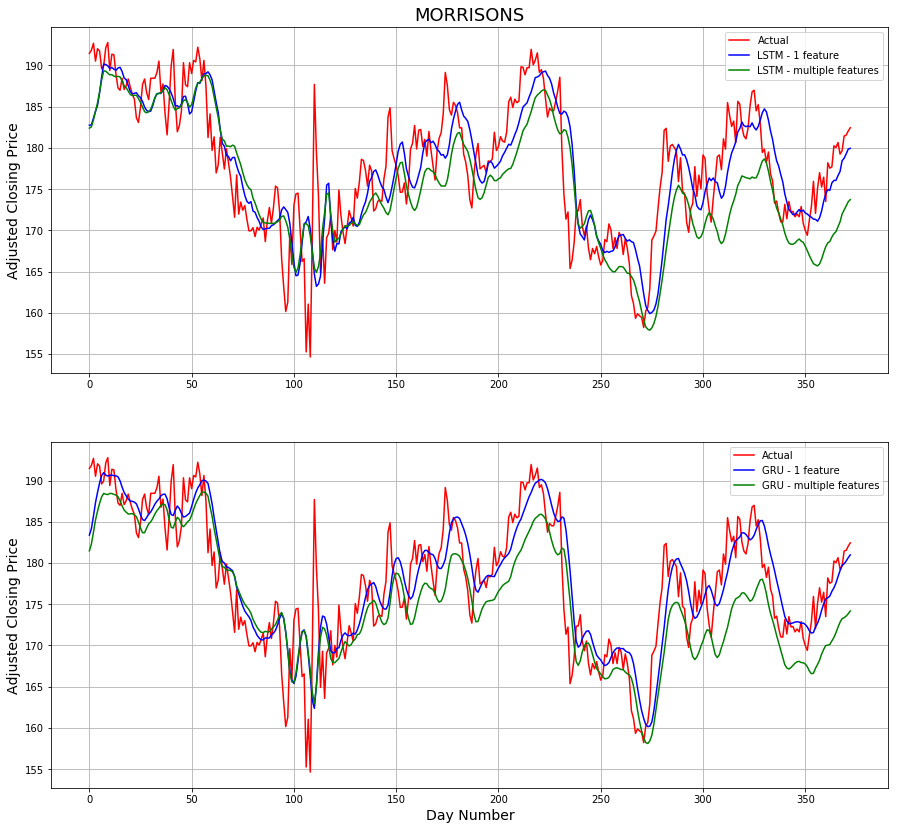

In [179]:
f = plt.figure(figsize=(15,14))
plt.subplot(211)
inv_yhat_lstm1, inv_y = retrieve_yvals(model=model_m, scaler=sc_m, X_test=X_test_m, y_test=y_test_m)
inv_yhat_lstm2, inv_y = retrieve_yvals(model=model_t_m, scaler=sc_t_m, X_test=X_test_t_m, y_test=y_test_t_m)
inv_y = remove_outliers(inv_y)

plt.plot(inv_y, color = 'red', label = 'Actual')
plt.plot(inv_yhat_lstm1, color='blue', label = 'LSTM - 1 feature')
plt.plot(inv_yhat_lstm2, color = 'green', label = 'LSTM - multiple features')
plt.ylabel('Adjusted Closing Price', size=14)
plt.grid()
plt.legend()
plt.title('MORRISONS', size=18)

plt.subplot(212)
inv_yhat_gru1, inv_y = retrieve_yvals(model=modelg_m, scaler=sc_m, X_test=X_test_m, y_test=y_test_m)
inv_yhat_gru2, inv_y = retrieve_yvals(model=modelg_t_m, scaler=sc_t_m, X_test=X_test_t_m, y_test=y_test_t_m)
inv_y = remove_outliers(inv_y)

plt.plot(inv_y, color = 'red', label = 'Actual')
plt.plot(inv_yhat_gru1, color='blue', label = 'GRU - 1 feature')
plt.plot(inv_yhat_gru2, color = 'green', label = 'GRU - multiple features')
plt.xlabel('Day Number', size=14)
plt.ylabel('Adjusted Closing Price', size=14)
plt.grid()
plt.legend()

## Best model - Sainsburys

In [151]:
#LSTM only adj close feature
model_s, model_history_s = build_LSTM(X_train_s, y_train_s,
                                  Validation_split=0.2,
                                  Dropout_level=0.25 ,
                                  Batch_size=84,
                                  Layers=2
                                 )

In [152]:
model_results(model_s, model_history_s, scaler = sc_s, X_test=X_test_s ,y_test=y_test_s)


###################
Test RMSE: 6.978
###################


###################
Test MAE: 5.445
###################


###################
Test R2: 0.870
###################



In [153]:
# LSTM multiple features
model_t_s, model_history_t_s = build_LSTM(X_train_t_s, y_train_t_s,
                                  Validation_split=0.2,
                                  Dropout_level=0.25 ,
                                  Batch_size=84,
                                  Layers=2
                                 )

In [154]:
model_results(model_t_s, model_history_t_s, scaler = sc_t_s, X_test=X_test_t_s ,y_test=y_test_t_s)


###################
Test RMSE: 7.267
###################


###################
Test MAE: 5.708
###################


###################
Test R2: 0.859
###################



In [116]:
#GRU with only adj close
modelg_s, modelg_history_s = build_GRU(X_train_s, y_train_s,
                                  Validation_split=0.2,
                                  Dropout_level=0.25 ,
                                  Batch_size=84,
                                  Layers=2
                                 )

In [155]:
model_results(modelg_s, modelg_history_s, scaler = sc_s, X_test=X_test_s ,y_test=y_test_s)


###################
Test RMSE: 5.838
###################


###################
Test MAE: 4.436
###################


###################
Test R2: 0.909
###################



In [156]:
#GRU with multiple features
modelg_t_s, modelg_history_t_s = build_GRU(X_train_t_s, y_train_t_s,
                                  Validation_split=0.2,
                                  Dropout_level=0.25 ,
                                  Batch_size=84,
                                  Layers=2
                                 )

In [157]:
model_results(modelg_t_s, modelg_history_t_s, scaler = sc_t_s, X_test=X_test_t_s ,y_test=y_test_t_s)


###################
Test RMSE: 6.183
###################


###################
Test MAE: 4.765
###################


###################
Test R2: 0.898
###################



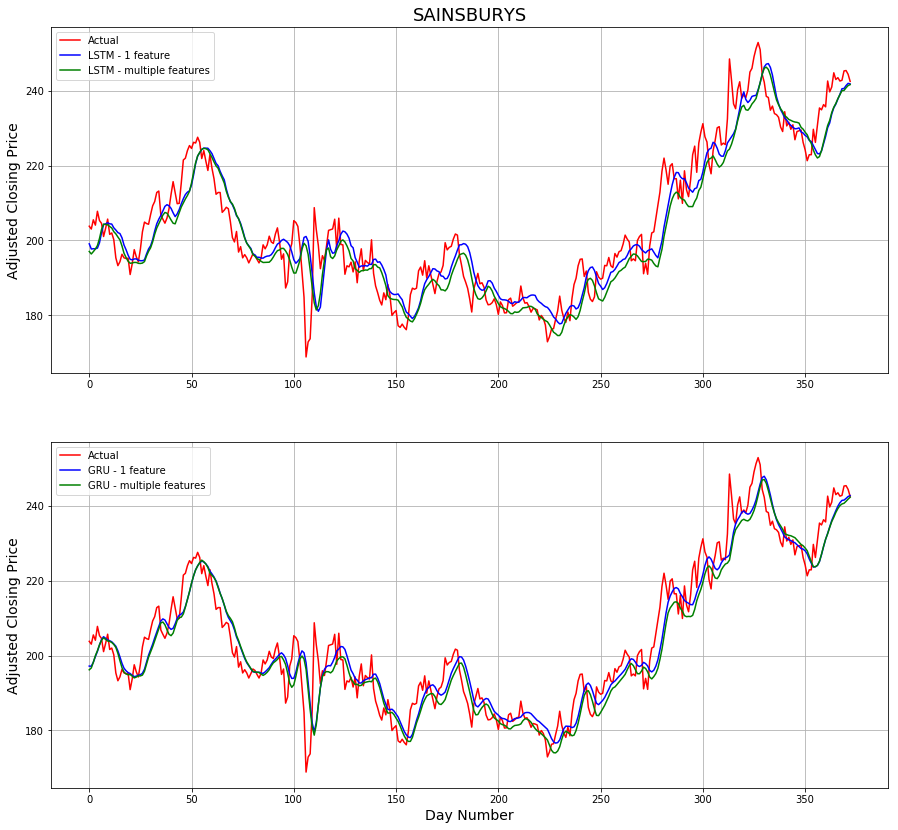

In [180]:
f = plt.figure(figsize=(15,14))
plt.subplot(211)
inv_yhat_lstm1, inv_y = retrieve_yvals(model=model_s, scaler=sc_s, X_test=X_test_s, y_test=y_test_s)
inv_yhat_lstm2, inv_y = retrieve_yvals(model=model_t_s, scaler=sc_t_s, X_test=X_test_t_s, y_test=y_test_t_s)
inv_y = remove_outliers(inv_y)

plt.plot(inv_y, color = 'red', label = 'Actual')
plt.plot(inv_yhat_lstm1, color='blue', label = 'LSTM - 1 feature')
plt.plot(inv_yhat_lstm2, color = 'green', label = 'LSTM - multiple features')
plt.ylabel('Adjusted Closing Price', size=14)
plt.grid()
plt.legend()
plt.title('SAINSBURYS', size=18)

plt.subplot(212)
inv_yhat_gru1, inv_y = retrieve_yvals(model=modelg_s, scaler=sc_s, X_test=X_test_s, y_test=y_test_s)
inv_yhat_gru2, inv_y = retrieve_yvals(model=modelg_t_s, scaler=sc_t_s, X_test=X_test_t_s, y_test=y_test_t_s)
inv_y = remove_outliers(inv_y)

plt.plot(inv_y, color = 'red', label = 'Actual')
plt.plot(inv_yhat_gru1, color='blue', label = 'GRU - 1 feature')
plt.plot(inv_yhat_gru2, color = 'green', label = 'GRU - multiple features')
plt.xlabel('Day Number', size=14)
plt.ylabel('Adjusted Closing Price', size=14)
plt.grid()
plt.legend()